# **AICookbook**

Ibuki Iwasaki, 4.453 Final Project

#setup

In [13]:
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.11.0+cu113
CUDA version: 11.3
cuDNN version: 8200
device: cuda
Fri May 20 08:25:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |  12263MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------

In [14]:
!git clone https://github.com/buksters/AICookbook  &> /dev/null
!git clone https://github.com/facebookresearch/inversecooking  &> /dev/null
!pip install rudalle==1.0.0 > /dev/null
!pip install ruclip==0.0.1rc7 > /dev/null
!pip install translators==4.9.5 > /dev/null


In [105]:
!git clone https://github.com/buksters/Flavor-Network  &> /dev/null

In [15]:
!mkdir image_results

mkdir: cannot create directory ‘image_results’: File exists


In [16]:
import translators
import ruclip
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_ruclip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything

#generate image using russian dalle

In [17]:
# device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.


In [18]:
realesrgan = get_realesrgan('x2', device=device) # x2/x4/x8
tokenizer = get_tokenizer()
vae = get_vae(dwt=True).to(device)  # for stable generations you should use dwt=False
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)
clip_predictor = ruclip.Predictor(clip, processor, device, bs=8)

x2 --> ready
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


In [19]:
def simple_detect_lang(text):
    if len(set('абвгдежзийклмнопрстуфхцчшщъыьэюяё').intersection(text.lower())) > 0:
        return 'ru'
    if len(set('abcdefghijklmnopqrstuvwxyz').intersection(text.lower())) > 0:
        return 'en'
    return 'other'

In [74]:
#@markdown choose two different cuisines
Cuisine_1 = 'Chinese' #@param ['American','Asian','Barbecue','Cajun & Creole','Chinese','Cuban','English','French','German','Greek','Hawaiian','Hungarian','Indian','Irish','Italian','Japanese','Mediterranean','Mexican','Moroccan','Portuguese','Southern & Soul Food','Southwestern','Spanish','Swedish','Thai']
Cuisine_2 = 'Indian' #@param ['American','Asian','Barbecue','Cajun & Creole','Chinese','Cuban','English','French','German','Greek','Hawaiian','Hungarian','Indian','Irish','Italian','Japanese','Mediterranean','Mexican','Moroccan','Portuguese','Southern & Soul Food','Southwestern','Spanish','Swedish','Thai']

text = f'{Cuisine_1} {Cuisine_2} Food'

if simple_detect_lang(text) != 'ru':
    text = translators.google(text, from_language='en', to_language='ru')
print('text:', text)

seed_everything(42)

pil_images = []
ppl_scores = []
for top_k, top_p, images_num in [
    (2048, 0.995, 24),
]:
    _pil_images, _ppl_scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, top_p=top_p, bs=8)
    pil_images += _pil_images
    ppl_scores += _ppl_scores

text: Китайская индийская еда


  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:89: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

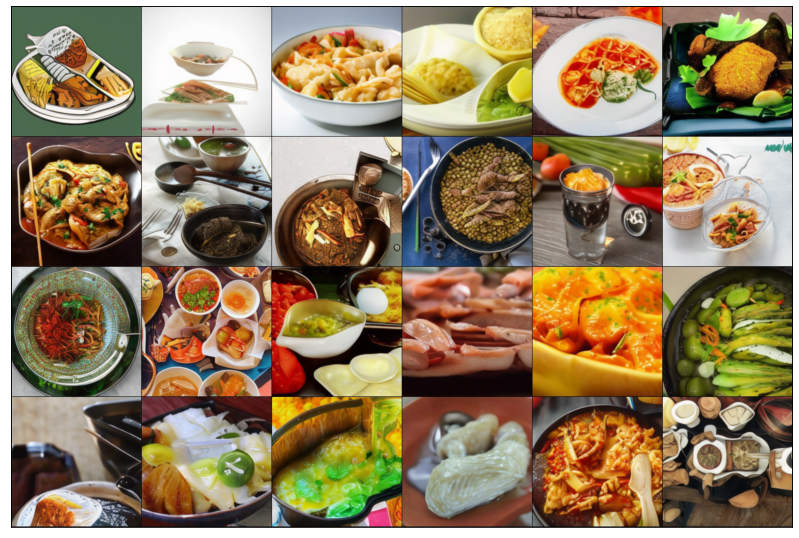

In [75]:
show(pil_images, 6)

24it [00:00, 125.83it/s]


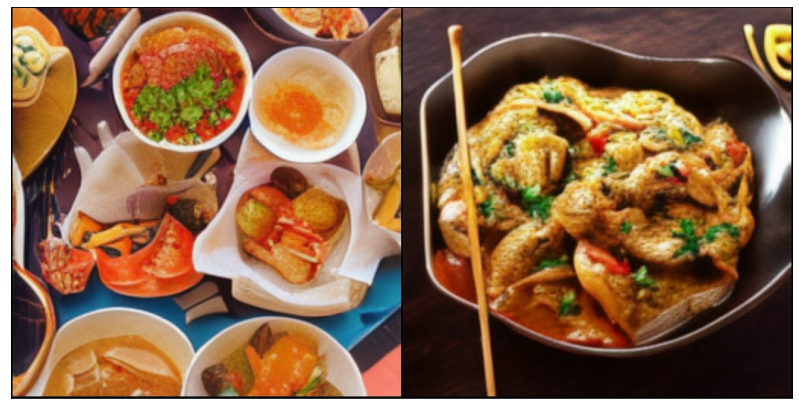

In [76]:
top_images, clip_scores = cherry_pick_by_ruclip(pil_images, text, clip_predictor, count=2)
show(top_images, 2)

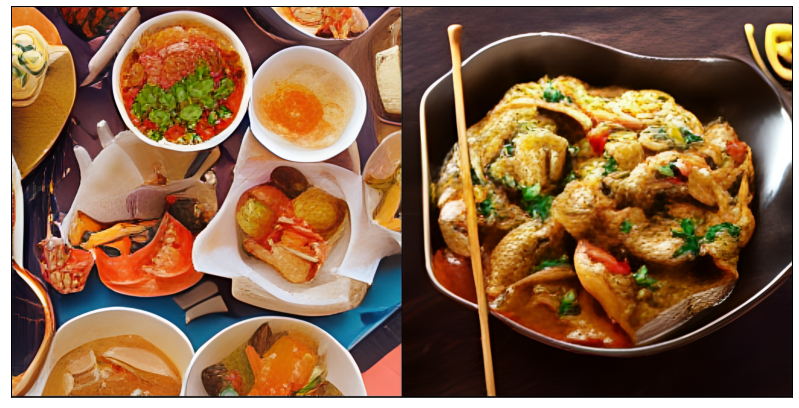

In [77]:
sr_images = super_resolution(top_images, realesrgan)
show(sr_images, 2)

In [78]:
%cd /content/
for n, img in enumerate(sr_images):
  file_name = f"image_results/{text}_sr_{n}.png"
  img.save(file_name)

/content


#generate recipe from previously generated image using inversecooking

make sure to upload ingr_vocab.pkl, instr_vocab.pkl, and modelbest.ckpt to inversecooking/data before running; files can be found here: https://github.com/facebookresearch/inversecooking

In [79]:
%cd inversecooking/src/
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
import model
from model import get_model
from torchvision import transforms
import utils
from utils.output_utils import prepare_output
from PIL import Image
import time

/content/inversecooking/src


In [80]:
%cd /content/inversecooking/
data_dir = './data'


/content/inversecooking


In [81]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = False
# device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [82]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [83]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [84]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 1.8845484256744385


In [85]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [86]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

In [87]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid


%cd /content/
image_folder = './image_results'

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    
    random.shuffle(demo_imgs)
    print(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

/content
['Китайская индийская еда_sr_1.png', '.ipynb_checkpoints', 'Китайская индийская еда_sr_0.png']


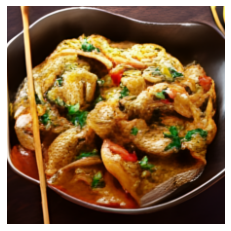

/content/inversecooking/src/modules/multihead_attention.py:128: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)
  float('-inf'),


RECIPE 1

Title: Chicken and egg white rice

Ingredients:
oil, pepper, egg, salt, clove, chicken, parsley, onion

Instructions:
-Heat the oil in a large skillet over medium heat.
-Add the onion and cook, stirring occasionally, until softened, about 5 minutes.
-Add the garlic and cook, stirring, until fragrant, about 30 seconds.
-Add the chicken and cook, stirring occasionally, until the chicken is browned, about 5 minutes.
-Add the piquillo peppers and cook, stirring occasionally, until the peppers are softened, about 5 minutes.
-Add the rice and cook, stirring, until the rice is heated through, about 2 minutes.
-Add the eggs and cook, stirring, until the eggs are set, about 2 minutes.
-Season with salt and pepper.
-Garnish with parsley and serve.
Not a valid recipe!
Reason:  no eos found
RECIPE 2

Title: Chicken and peppers

Ingredients:
oil, pepper, egg, salt, clove, chicken, parsley, onion

Instructions:
-Heat the oven to 425; spread the bell peppers in a roasting pan.
-Roast until 

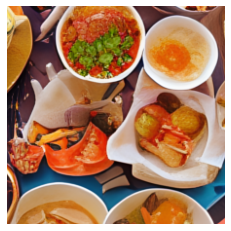

RECIPE 1

Title: Tomato sauce

Ingredients:
onion, pepper, oil, salt, clove, tomato, chili

Instructions:
-Heat the oil in a large saucepan over medium heat.
-Add the onion and garlic and cook, stirring occasionally, until the onion is translucent, about 5 minutes.
-Add the tomatoes, chili powder, salt and pepper and bring to a boil.
-Reduce the heat to low and simmer, stirring occasionally, until the tomatoes are very soft, about 30 minutes.
-Remove from the heat and let cool slightly.
-Transfer the sauce to a blender and puree until smooth.
Not a valid recipe!
Reason:  no eos found
RECIPE 2

Title: Roasted tomato paste

Ingredients:
onion, pepper, oil, salt, clove, tomato, chili

Instructions:
-Preheat oven to 400 degrees f. cut top and bottom off tomatoes and reserve for another use.
-Peel and core tomatoes, then cut into quarters.
-Arrange tomatoes in a single layer in a shallow casserole.
-Sprinkle tomatoes with salt, then drizzle with olive oil and sprinkle with chili powder.
-Ro

In [88]:
img_ingrs = {img:[] for img in demo_files}

for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        if 'ipynb' in image_path:
          continue
        # image = Image.open(image_path).convert('RGB')
        image = Image.open(image_path)
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i],temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)

        if not img_ingrs[img_file]:
          img_ingrs[img_file] = outs['ingrs']
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])

In [92]:
print(img_ingrs)

{'Китайская индийская еда_sr_1.png': ['oil', 'pepper', 'egg', 'salt', 'clove', 'chicken', 'parsley', 'onion'], '.ipynb_checkpoints': [], 'Китайская индийская еда_sr_0.png': ['onion', 'pepper', 'oil', 'salt', 'clove', 'tomato', 'chili']}


In [106]:
import pandas as pd
%cd /content/Flavor-Network/code/

import recipe_clustering
%cd /content/Flavor-Network
%ls

/content/Flavor-Network/code
/content/Flavor-Network
code/  data/  Flavor-Network/  images/  LICENSE  presentation/  readme.md


(478, 349) [0, 190, 478]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the 

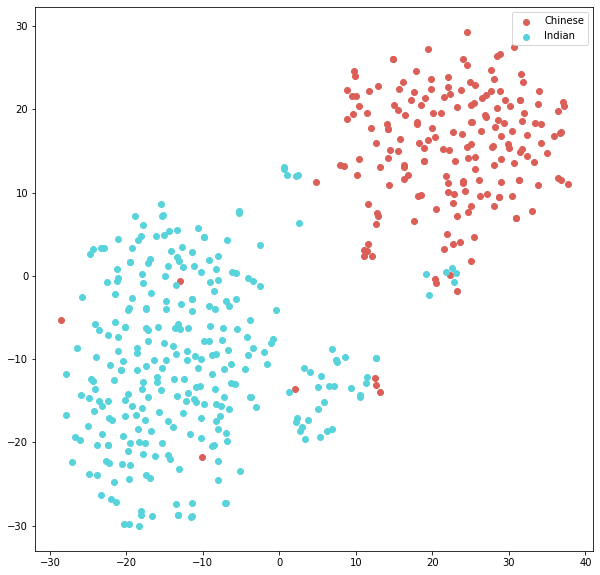

In [107]:
yum_ingr = pd.read_pickle('./data/yummly_ingr.pkl')
yum_ingrX = pd.read_pickle('./data/yummly_ingrX.pkl')
yum_tfidf = pd.read_pickle('./data/yummly_clean.pkl')

#select four cuisines and plot tsne clustering with ingredients
sublist = [Cuisine_1, Cuisine_2]
df_ingr = yum_ingrX.copy()
df_ingr['cuisine'] = yum_ingr['cuisine']
df_ingr['recipeName'] = yum_ingr['recipeName']
recipe_clustering.tsne_cluster_cuisine(df_ingr,sublist)


In [99]:
set(df_ingr['cuisine'])


,almond,anise,anise seed,apple,apple juice,apricot,artichoke,asparagus,avocado,bacon,...,whole grain wheat flour,wild rice,wine,wood,yam,yeast,yogurt,zucchini,cuisine,recipeName
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Southern & Soul Food,Southern Cornbread Dressing
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,American,Disappearing Buffalo Chicken Dip
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Southern & Soul Food,Classic Coleslaw
12,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,American,Creamed Spinach
13,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,American,Eggs in Hash Brown Nests
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8658,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Thai,Thai Coconut Shrimp Soup
8659,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Thai,Thai-Style Broiled Shrimp
8660,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Thai,Pad Thai French Fries
8661,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,Thai,Spicy Thai Lobster Soup
